In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
from utils import sample_shuffler # Custom utility function

## Data / Goal
The goal is to predict which customers will buy a SUV, so a business can target social media adverts accordingly. The dataset has 400 observations. The independent variables are age and salary. The dependent variable is binary, with 1 = bought SUV, and 0 = did not buy SUV.

In [2]:
dataset = pd.read_csv('data/Social_Network_Ads.csv')
purchased = dataset[dataset["Purchased"] == 1]
non_purchased = dataset[dataset["Purchased"] == 0]
print(f'Purchased SUV count: {purchased.shape}')
print(f'Did not purchase SUV count: {non_purchased.shape}')


Purchased SUV count: (143, 3)
Did not purchase SUV count: (257, 3)


## Exploratory Data Analysis
Correlation between age and salary is low, although individuals under the age of 30 tend not to earn very high salaries. It also appears people under the age of 30 tend not to buy SUV's (probably because they are less likely to have offspring). There does not appear to be many outliers.

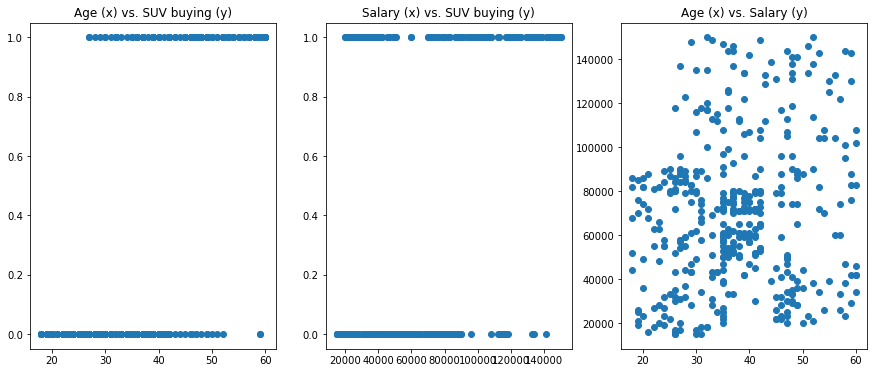

In [3]:
X=dataset.iloc[:,:-1].values
y=dataset.iloc[:,-1].values

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (15,6))
ax1.scatter(X[:,0], y)
ax1.set_title("Age (x) vs. SUV buying (y)")
ax2.scatter(X[:,1], y)
ax2.set_title("Salary (x) vs. SUV buying (y)")
ax3.scatter(X[:,0],X[:,1])
ax3.set_title("Age (x) vs. Salary (y)")
plt.tight_layout
plt.show()

## K-Nearest Neighbours
**Preprocessing**: The dataset is imbalanced. This can be problematic for KNN as predictions are made on nearby datapoints. We make the dataset balanced by 'upsampling' the small class (people who don't buy SUV's) and 'downsampling' the large class (people who buy SUV's). This creates 200 observations for each class. We then split the data set into 75% training, and 25% test.

**Approach**: KNN makes predictions by identifying the closest 'K' data points to a query point. 'Distance' is calculated in order to find the closest data points. Typically this is 'euclidean'. 'K' is a hyperparameter to be tuned. Low values of 'K' create very flexible models (with high variance) and high values of 'K' create stable / robust models (with high bias).

**Advantages/disadvantages**: KNN is very good at learning non-linear / complex functions as all that is considered is the local area around a query point. This makes it a poor classifier for sparse / high dimensional feature space. The main draw back is all computation is reserved until a query is made (no function is learnt). Computations can also become quite large because many distances need to be calculated before the closest neigbours can be found.

**Results**: Accuracy of 89%. 'K' is a hyperparameter to be tuned. By using GridSearch() we find K=6 produces the highest accuracy. It achieves 94% on the test dataset.

In [4]:
print(f'Before Sampling: Number of non_purchased = {non_purchased.shape}, number of purchased = {purchased.shape}')
non_purchased,purchased = sample_shuffler(list(non_purchased.values), list(purchased.values), 
                        sample_type = "split", shuffle = "True", random_seed = False)
non_purchased,purchased = np.array(non_purchased), np.array(purchased)
print(f'After sampling: Number of non_purchased = {non_purchased.shape}, number of purchased = {purchased.shape}')
dataset = np.concatenate((non_purchased, purchased), axis = 0)
X = dataset[:,:2]
y = dataset[:,-1]

Before Sampling: Number of non_purchased = (257, 3), number of purchased = (143, 3)
After sampling: Number of non_purchased = (200, 3), number of purchased = (200, 3)


In [5]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25, shuffle = True, stratify = y, random_state=0)
pipeline = Pipeline([('sc', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=6, algorithm='kd_tree'))])
model = pipeline.fit(X_train, y_train)
predictions = model.predict(X_test)

param_grid = {'clf__n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
grid = GridSearchCV(pipeline, param_grid, scoring='accuracy')
grid.fit(X_train, y_train)
print(f'Best score: {grid.best_score_}')
print(f'Best params_: {grid.best_params_}')

cm = confusion_matrix(y_test,predictions)
print(cm)
accuracy_score(y_test,predictions)

Best score: 0.93
Best params_: {'clf__n_neighbors': 9}
[[43  7]
 [ 3 47]]


0.9

In [6]:
np.sum(y_train)
y_train.shape

(300,)

## Testing for 'K'
The subplots below show how the KNN classifier divides up a feature space for different values of 'K'. At one extreme, where K=1, the classifier creates a fragmented feature space where single data points heavily influence predictions, even if they happen to be outliers. The test set accuracy is 87% (very high variance). As the value for 'K' increases the boundary line becomes smoother and less prone to overfitting.

In [7]:
def all_feature_plots(X_train, y_train, X_test, y_test, K = [5], shape = (5,5), figsize = (8,30)):
    """ Generates subplots of features variables against dependent variable (scatter if continous, else Boxplot) """
    fig, axes = plt.subplots(shape[0], shape[1], figsize = figsize, sharey = True)
    for ind, ax in zip(K, axes.flatten()):
        pipeline = Pipeline([('sc', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=ind, algorithm='kd_tree'))])
        model = pipeline.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test,predictions)

        X_set = X_test
        y_set = y_test
        X1, X2 = np.meshgrid(np.linspace(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, num=200),
                             np.linspace(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, num=200))
        ax.contourf(X1, X2, model.predict((np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
                     alpha = 0.75, cmap = ListedColormap(('red', 'green')))
        for i, j in enumerate(np.unique(y_set)):
            ax.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], color = ListedColormap(('red', 'green'))(i), label = j)
        ax.set_title(f'K = {ind} (Test Set), Test Accuracy = {accuracy}')
        ax.set_xlabel('Age')
        ax.set_ylabel('Estimated Salary')
    plt.legend()
    plt.show()

all_feature_plots(X_train, y_train, X_test, y_test, K = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29], shape = (3,4), figsize=(25,15))